In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
from dataclasses import dataclass
from scipy.interpolate import interp1d
from scipy.misc import derivative

### Goal questions

I don't have much experience with biodiversity data at all tbh. This all kind of new to me. However, new is exciting and exciting is challenging so I'll come at this with a naive positivity point of view.

There are guide questions that needs to be answered. I do feel that these are still big questions and I plan to divide it into <i>smaller questions that are easier to answer.</i>


#### Is the biodiversity in this area endangered? To what degree?**
- How do we define biodiversity?
- Is there a metric/index that is readily available to do this?
- What kind of dataset do we need in order to get a good read on the state of biodiversity?
- Maybe find similar cases where biodiversity was preserved/destroyed?

#### What are the biggest risks to biodiversity in the area?
- What are the different risk factors to biodiversity?
- How can we classify if a certain factor is categorized as risk

#### Which biodiversity class is the most endangered?
- How do we define "endangered"?
- What are the different classes/categories in which we can classify biodiversity?

#### How might habitat loss change the biodiversity in this area?
- Can we find similar cases that can support the effect of habitat loss?
- How can we mitigate habitat loss in the first place? 
- Is there a certain threshold that defines an irreversible habitat loss effect?

#### Calculate a biodiversity index/metric that communicates the state of biodiversity in a single number (explain your working and any sources you may have used to build this)
- I think this is the most technically challenging part
- Can we define a single number for this? This is a multiclass/multivariable type of problem, maybe we can assign different weights to those important variables to be able to create a single value? Might be difficult to represent outliers though :(

---------------------------

Some stuff to check, ideas at the top of my head

- Simpson's Diversity 
- Diversity index over time (?)
- Show a mapping of the diversity data

In [2]:
heading = pd.read_csv("data/headings.csv")
heading.head(len(heading))

,Column name,Requested field,DwC Name,Field name,Field description,Download field name,Download field description,More information
0,images,imageIDs,images,imageIDs,images,imageIDs,images,Image URLs for this record http://rs.tdwg.org/...
1,raw_recordedBy,raw_recordedBy,NaN,raw_recordedBy,recordedBy (unprocessed),raw_recordedBy,Collector - original,NaN
2,dcterms:modified,modified,dcterms:modified,modified,NaN,modified,NaN,NaN
3,dcterms:language,language,dcterms:language,language,NaN,language,NaN,Language of the record
4,dcterms:license,license,dcterms:license,license,License,license,Licence,The license applying to a record.
...,...,...,...,...,...,...,...,...
198,measurementDeterminedBy,measurementDeterminedBy,measurementDeterminedBy,measurementDeterminedBy,Measurement Determined By,measurementDeterminedBy,NaN,http://rs.tdwg.org/dwc/terms/measurementDeterm...
199,measurementAccuracy,measurementAccuracy,measurementAccuracy,measurementAccuracy,Measurement Accuracy,measurementAccuracy,NaN,http://rs.tdwg.org/dwc/terms/measurementAccuracy
200,relatedResourceID,relatedResourceID,relatedResourceID,relatedResourceID,Related Resource ID,relatedResourceID,NaN,http://rs.tdwg.org/dwc/terms/relatedResourceID
201,images,imageIDs,images,imageIDs,images,imageIDs,images,Image URLs for this record http://rs.tdwg.org/...


In [3]:
data = pd.read_csv("data/schofield_radius_5_.csv", low_memory=False)
data.head(5)

,dataResourceUid,images,raw_recordedBy,dcterms:modified,dcterms:language,dcterms:license,rightsHolder,dcterms:accessRights,dcterms:bibliographicCitation,references,...,verbatimScientificName,verbatimContinent,measurementID,measurementType,measurementUnit,measurementDeterminedBy,measurementAccuracy,relatedResourceID,images.1,dcterms:type
0,dr1010,NaN,NaN,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,...,Ocyphaps lophotes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,dr1010,NaN,observation,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,...,Rwaida Maragan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dr1010,NaN,NaN,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,...,Ocyphaps lophotes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dr1010,NaN,NaN,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,...,Pteropus poliocephalus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,dr1010,NaN,97cfbd084e3a198764e9630f6ea694eccdb32c55,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,...,Doryanthes excelsa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Quick cleanup

- Just remove columns that contains `null` values for all data points
- Check columns that contain only one unique value, see if they can be removed
- Add a proper datetime column for easier filters
- **ASSUMPTION**: The `individualCount` column seems to represent only visual events. There are other columns that has `NaN` values but contain other type of events, e.g. sound, etc. Just assign `1` for these events. Create a `final_count` col just to be sure.

In [4]:
# basisOfRecord - what kind of observation is done
# individualCount - number of counted organism?
empty_cols = []
for c in data.columns:
    if data[c].isnull().values.all():
        empty_cols.append(c)
        
# Drop columns with all empty values
pd.set_option("display.max_columns", None)
data_without_empty = data.drop(empty_cols, axis=1)

# Check columns with only one value, see if they can all be removed
cols_with_one_value = []
for c in data_without_empty.columns:
    if data_without_empty[c].nunique() == 1:
        print(data_without_empty[c].value_counts())
        cols_with_one_value.append(c)

cleaned_data = data_without_empty.drop(cols_with_one_value, axis=1)        
cleaned_data["date_clean"] = pd.to_datetime(cleaned_data.eventDate)
cleaned_data["final_count"] = cleaned_data.individualCount.fillna(1)

cleaned_data.head(3)

dcterms:language
en    23088
Name: count, dtype: int64
dcterms:accessRights
https://florabase.dpaw.wa.gov.au/help/copyright    5
Name: count, dtype: int64
occurrenceStatus
PRESENT    32688
Name: count, dtype: int64
organismID
white patch around genitals    1
Name: count, dtype: int64
organismRemarks
A stringybark.    2
Name: count, dtype: int64
waterBody
not applicable    17
Name: count, dtype: int64
islandGroup
not applicable    17
Name: count, dtype: int64
island
not applicable    17
Name: count, dtype: int64
country
Australia    32688
Name: count, dtype: int64
countryCode
AU    32688
Name: count, dtype: int64
stateProvince
New South Wales    32688
Name: count, dtype: int64
geodeticDatum
EPSG:4326    32688
Name: count, dtype: int64
georeferenceVerificationStatus
verified    571
Name: count, dtype: int64
georeferenceRemarks
Grid not provided, assumed MGA.    83
Name: count, dtype: int64
typeStatus
SYNTYPE    1
Name: count, dtype: int64


,dataResourceUid,images,raw_recordedBy,dcterms:modified,dcterms:license,rightsHolder,dcterms:bibliographicCitation,references,institutionID,collectionID,datasetID,institutionCode,collectionCode,datasetName,ownerInstitutionCode,basisOfRecord,dataGeneralizations,dynamicProperties,occurrenceID,catalogNumber,recordNumber,recordedBy,individualCount,sex,lifeStage,reproductiveCondition,behavior,establishmentMeans,preparations,disposition,associatedMedia,associatedReferences,associatedTaxa,otherCatalogNumbers,occurrenceRemarks,associatedOccurrences,previousIdentifications,eventID,fieldNumber,eventDate,eventTime,year,month,day,verbatimEventDate,habitat,samplingProtocol,samplingEffort,fieldNotes,eventRemarks,locationID,higherGeography,county,municipality,locality,locality.1,verbatimLocality,minimumElevationInMeters,maximumElevationInMeters,verbatimElevation,locationAccordingTo,locationRemarks,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,verbatimCoordinates,verbatimLatitude,verbatimLatitude.1,verbatimLongitude,verbatimLongitude.1,verbatimCoordinateSystem,verbatimCoordinateSystem.1,verbatimSRS,georeferencedBy,georeferencedDate,georeferenceProtocol,georeferenceSources,identificationID,identificationQualifier,identifiedBy,dateIdentified,identificationVerificationStatus,identificationRemarks,taxonID,scientificNameID,acceptedNameUsageID,taxonConceptID,scientificName,acceptedNameUsage,parentNameUsage,nameAccordingTo,higherClassification,kingdom,phylum,class,order,family,genus,subgenus,specificEpithet,infraspecificEpithet,taxonRank,verbatimTaxonRank,scientificNameAuthorship,vernacularName,nomenclaturalCode,taxonomicStatus,taxonRemarks,verbatimBasisOfRecord,species,provenance,sounds,recordID,rights,verbatimScientificName,verbatimContinent,images.1,dcterms:type,date_clean,final_count
0,dr1010,NaN,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OBSERVATION,NaN,"{""nestPresent"":""No"",""recorderID"":""1188""}",NaN,534167b03f905e2143000011,NaN,NaN,3.0,NaN,NaN,NaN,Feeding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-27T03:40:00Z,NaN,2014.0,3.0,27.0,NaN,Nature reserve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.750613,150.862390,1000.0,NaN,NaN,150.862390,NaN,-33.750613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://biodiversity.org.au/afd/taxa/a7b00ef0-...,Ocyphaps lophotes,NaN,NaN,NaN,NaN,Animalia,Chordata,Aves,Columbiformes,Columbidae,Ocyphaps,NaN,NaN,NaN,species,NaN,"(Temminck, 1822)",Crested Pigeon,NaN,NaN,NaN,observation,Ocyphaps lophotes,Published dataset,NaN,9fe3ad43-b9b9-4a7d-8502-5a0ad252ad0f,NaN,Ocyphaps lophotes,NaN,NaN,NaN,2014-03-27 03:40:00+00:00,3.0
1,dr1010,NaN,observation,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OCCURRENCE,NaN,"{""Treehealth"":""Healthy"",""Phenophase/Behaviour""...",NaN,58d7711a94cf704301000077,NaN,Observation,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-03-26T18:43:25Z,NaN,2017.0,3.0,26.0,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.737027,150.860172,1000.0,NaN,NaN,-33.737027,NaN,150.860172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pencil Pine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pending,NaN,Published dataset,NaN,3b07c436-56f7-4693-802a-6450e4f90c6a,NaN,Rwaida Maragan,NaN,NaN,NaN,2017-03-26 18:43:25+00:00,1.0
2,dr1010,NaN,NaN,NaN,CC-BY 3.0 (Int),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OBSERVATION,NaN,"{""nestPresent"":""No"",""recorderID"":""869""}",NaN,551b4ff394cf70042a000008,NaN,NaN,2.0,NaN,NaN,NaN,Courting or Mating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,They weren't interacting with each other but i...,NaN,NaN,NaN,NaN,2015-04-01T21:43:00Z,NaN,2015.0,4.0,1.0,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-33.727381,150.883611,1000.0,NaN,NaN,-33.727381,NaN,150.883611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Separate the data into more manageable groups

- One way to do this is to separate the animals and the plant data. 
- It might be better to break the data down into smaller subgroups as well
- Easier to apply/search for patterns in smaller datasets

In [5]:
# Other dataset have 1-3 rows only, maybe ignore for now
plant_data = cleaned_data[cleaned_data.kingdom == "Plantae"]
animal_data = cleaned_data[cleaned_data.kingdom == "Animalia"]
fungi_data = cleaned_data[cleaned_data.kingdom == "Fungi"]

/var/folders/v_/cts5g9214kd1_ft27mb5zm240000gn/T/ipykernel_18489/1070771903.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  animal_yearly = animal_data.final_count.groupby(animal_data.date_clean.dt.to_period("M")).agg("sum")
/var/folders/v_/cts5g9214kd1_ft27mb5zm240000gn/T/ipykernel_18489/1070771903.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  plant_yearly = plant_data.final_count.groupby(plant_data.date_clean.dt.to_period("M")).agg("sum")


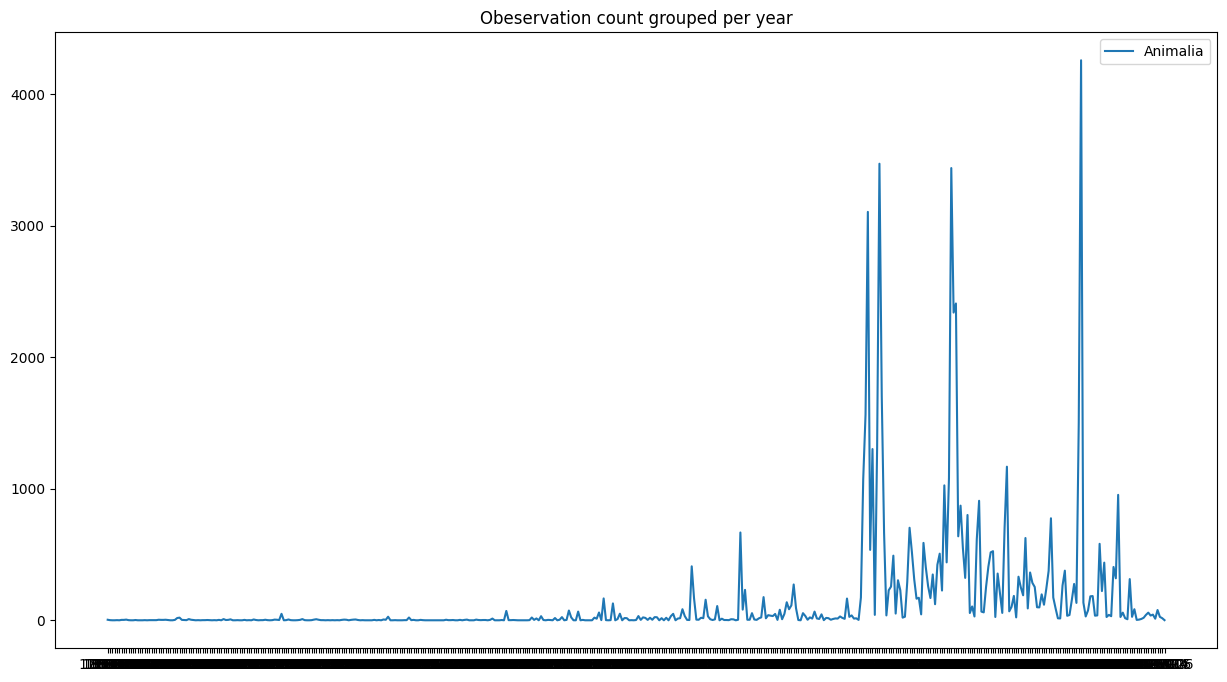

In [6]:
animal_yearly = animal_data.final_count.groupby(animal_data.date_clean.dt.to_period("M")).agg("sum")
plant_yearly = plant_data.final_count.groupby(plant_data.date_clean.dt.to_period("M")).agg("sum")
fungi_yearly = fungi_data.final_count.groupby([fungi_data.date_clean.dt.year]).agg("sum")

plt.figure(figsize=(15, 8))
plt.plot(animal_yearly.index.to_series().astype(str).values, animal_yearly.values, label="Animalia")
# plt.plot(plant_yearly.index.to_series().astype(str).values, plant_yearly.values, label="Plantae")
# plt.plot(fungi_yearly.index, fungi_yearly.values, label="Fungi")
# plt.yscale("log")
plt.title("Obeservation count grouped per year")
plt.legend()
plt.show()
# len(plant_yearly.index.to_series().astype(str).values)
# len(plant_yearly.values)

In [7]:
start_date = "1990-1-1"
end_date = "2021-12-31"

def get_date_bounded(df, start_date, end_date):
    """Filters the data with the given date range"""

    mask = (df.date_clean > start_date) & (df.date_clean <= end_date)
    bounded_df = df[mask]
    return bounded_df
    
a_bdf = get_date_bounded(animal_data, start_date, end_date)
p_bdf = get_date_bounded(plant_data, start_date, end_date)

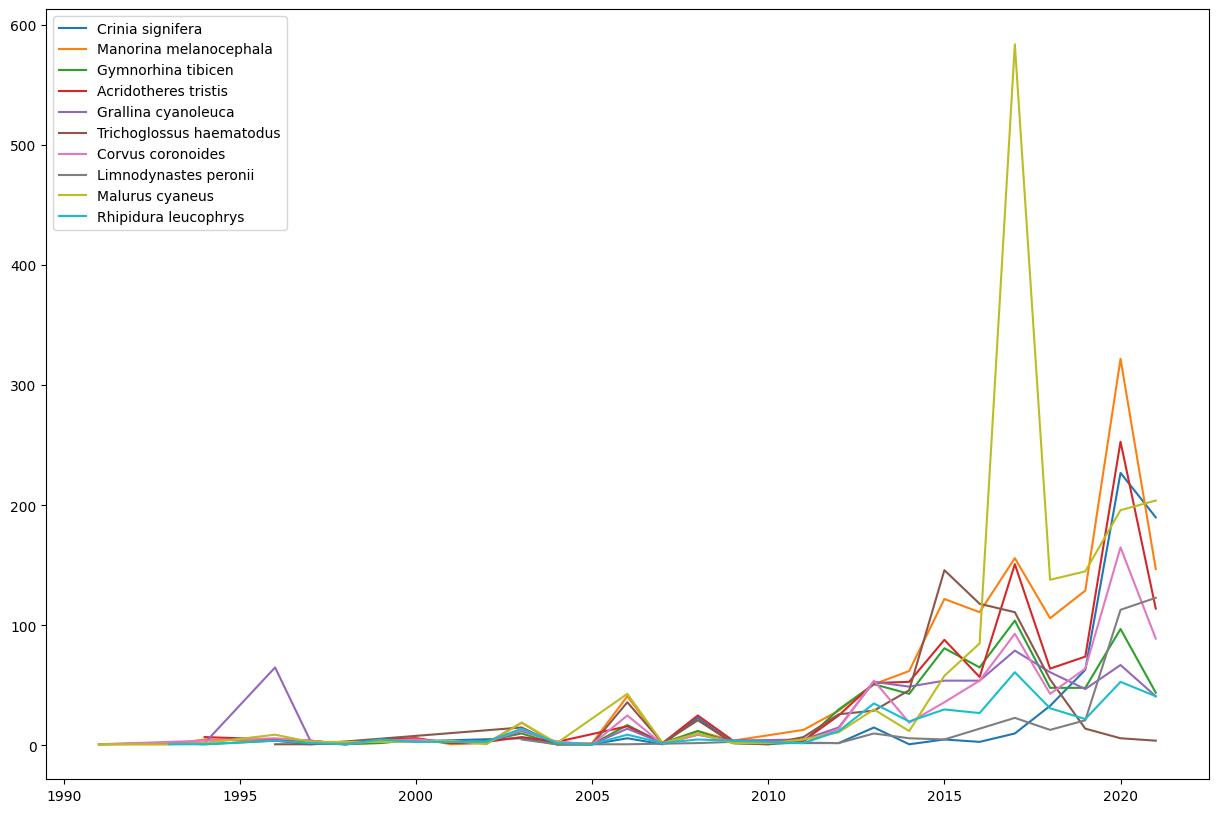

In [8]:
def show_historical_graph_per_species(df, top=10, title=""):
    """Show historical record of top N species data"""
    # IMPOTANT NOTE
    # individualCount - only represents visual observation. Sound observations can also be made
    plt.figure(figsize=(15,10))
    top_species = df.species.value_counts()[:top].index
    for spc in top_species:
        agg = df[df.species == spc].groupby(df.date_clean.dt.year)['final_count'].sum()
        plt.plot(agg.index, agg.values, label=spc)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
show_historical_graph_per_species(a_bdf)

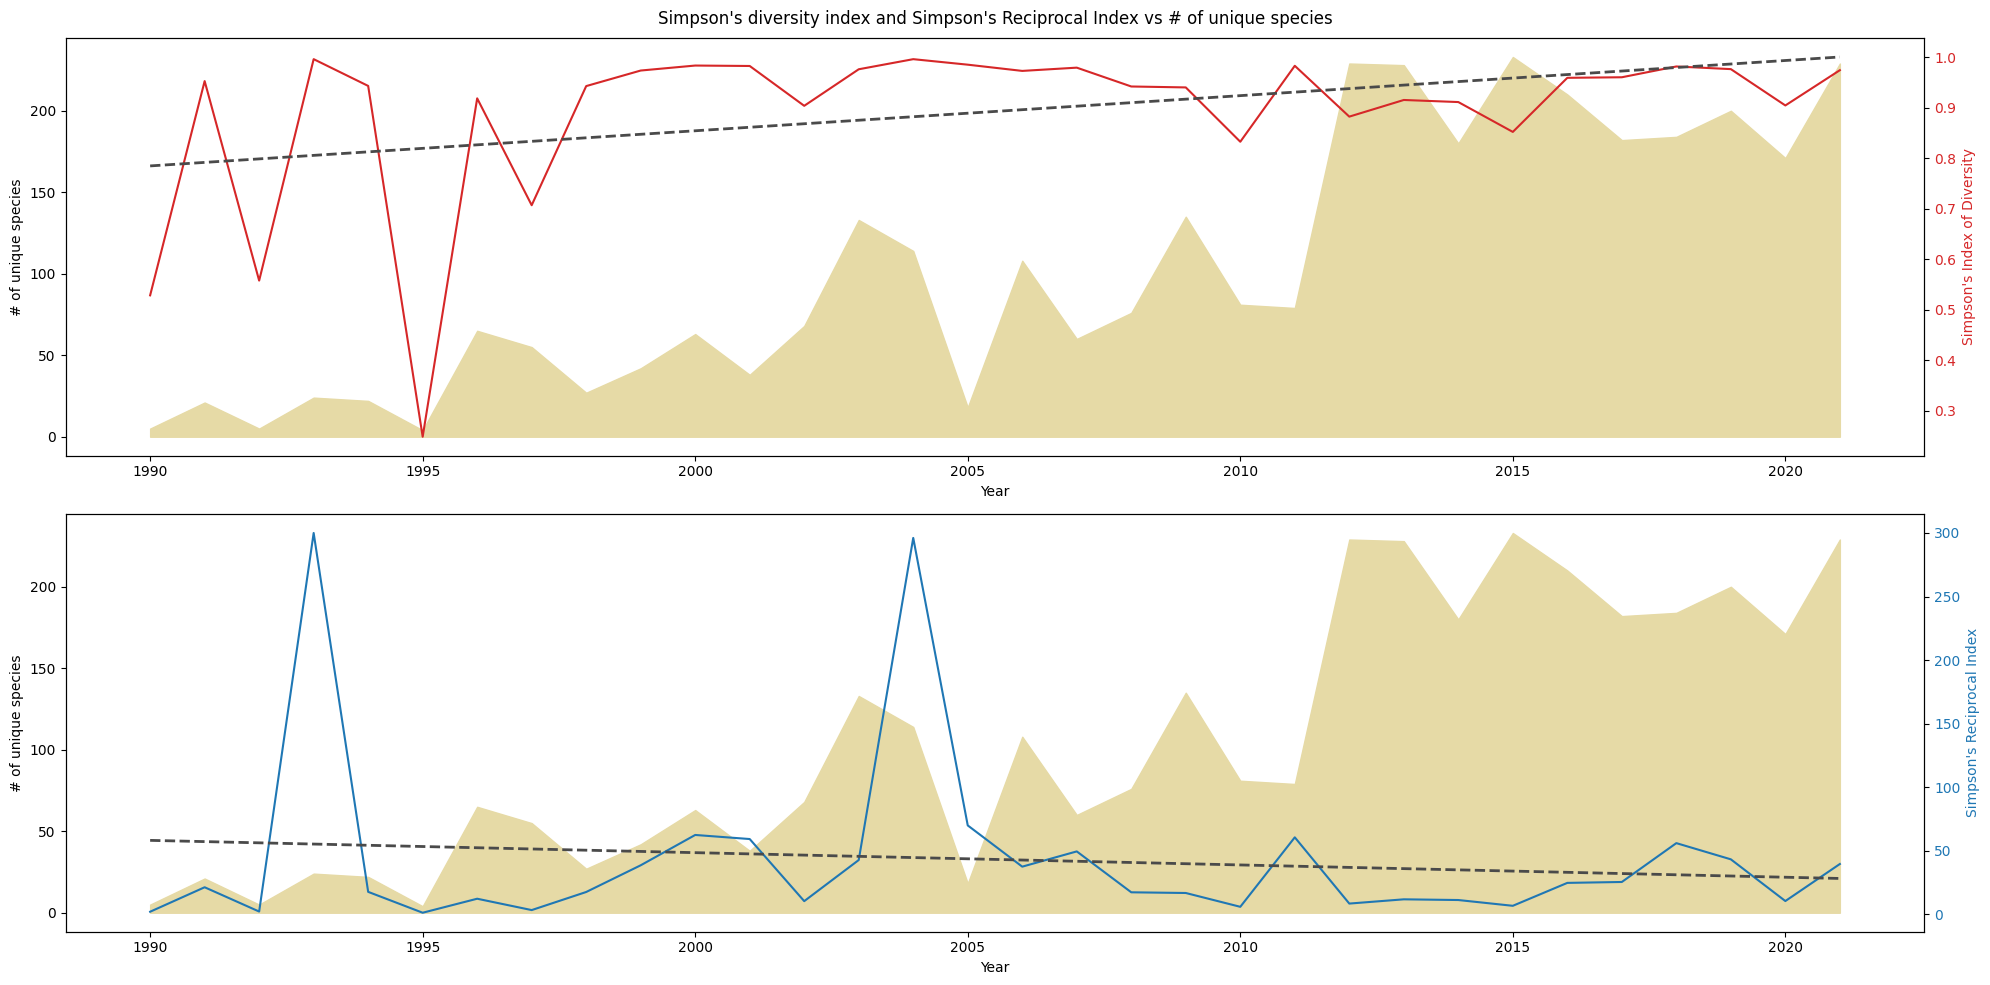

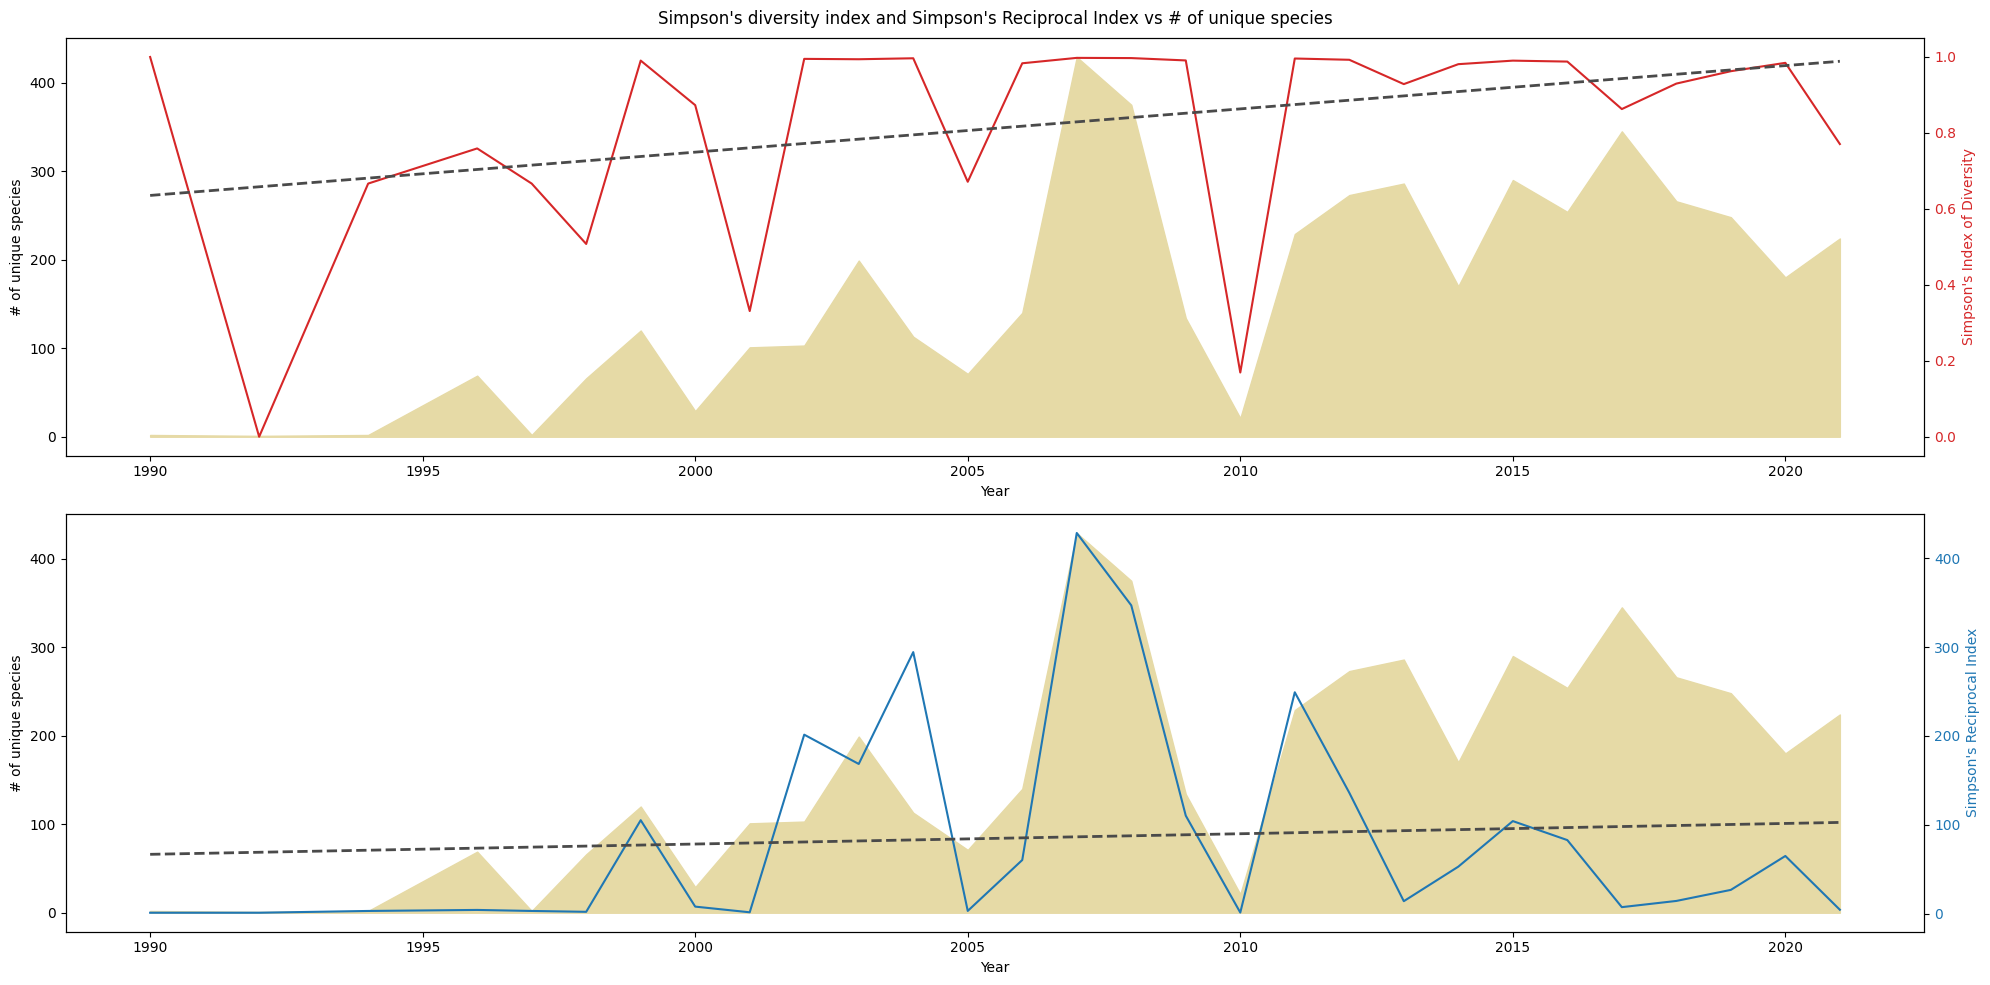

In [9]:
useful_cols = ["individualCount", "year", "references", "basisOfRecord", "occurrenceID", "date_clean", "final_count"]

def get_species_divserity_score(df):
    """
    Uses simpson's diversity index to get a year on year score.
    
    Sources:
    https://www.youtube.com/watch?v=7DOuku8876I
    http://www.countrysideinfo.co.uk/simpsons.htm
    https://geographyfieldwork.com/Simpson'sDiversityIndex.htm
    
    Will use Simpson's Reciprocal Index and Simpson's index
    - its easier to understand, score range is 1-N where N is total number of species
    - not affected by rare species count
    N(N-1) / sum(n(n-1))
    """
    year_range = df.date_clean.dt.year.unique()
    yoy_index = []

    for year in year_range:
        _count = df[df.date_clean.dt.year == year].final_count.groupby([df.species]).agg("sum").values
        _total = 0
        for v in _count:
            _total += v * (v-1)
        
        _n = sum(_count)        
        index = _total / ((_n * (_n - 1)) or 1)
        r_index = 1 / (index or 1)
        # print(year ,len(_count), _total)
        # Return year, index, and total # of species, # total num of organism
        yoy_index.append((year, 1 - index, r_index, len(_count), _n))
    return np.array(sorted(yoy_index))

def display_simpsons_index(data):
    """
    Shows a graph of unique species count vs simpsons index and reciprocal index
    """
    fig, (ax1, ax2) = plt.subplots(2, figsize=(20,10))
    ax1.set_xlabel("Year")
    ax2.set_xlabel("Year")
    
    ax1.fill_between(data[:, 0], data[:, 3], color="#E6DAA6", label="# of unique species")
    _ax1 = ax1.twinx()  
    _ax1.set_ylabel("Simpson's Index of Diversity", color="tab:red")  # we already handled the x-label with ax1
    _ax1.plot(data[:, 0], data[:, 1], color="tab:red", label="Simpson's Index of Diversity") 
    ax1.set_ylabel("# of unique species")
    _ax1.tick_params(axis='y', labelcolor="tab:red")
    
    # add trend line
    z = np.polyfit(data[:, 0], data[:, 1], 1)
    p = np.poly1d(z)
    _ax1.plot(data[:, 0], p(data[:, 0]), color="#4a4a4a", linewidth=2, linestyle="--")
    
    ax2.fill_between(data[:, 0], data[:, 3], color="#E6DAA6", label="# of unique species")
    _ax2 = ax2.twinx()  
    _ax2.set_ylabel("Simpson's Reciprocal Index", color="tab:blue")  # we already handled the x-label with ax1
    _ax2.plot(data[:, 0], data[:, 2], color="tab:blue", label="Simpson's Reciprocal Index)")
    ax2.set_ylabel("# of unique species")
    _ax2.tick_params(axis='y', labelcolor="tab:blue")
    
    # add trend line
    z = np.polyfit(data[:, 0], data[:, 2], 1)
    p = np.poly1d(z)
    _ax2.plot(data[:, 0], p(data[:, 0]), color="#4a4a4a", linewidth=2, linestyle="--")


    fig.suptitle("Simpson's diversity index and Simpson's Reciprocal Index vs # of unique species")
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

animal_index = get_species_divserity_score(a_bdf)
plant_index = get_species_divserity_score(p_bdf)

display_simpsons_index(animal_index)
display_simpsons_index(plant_index)

In [10]:
p_bdf[p_bdf.date_clean.dt.year == 2011].final_count.groupby([p_bdf.species]).agg("sum").values

array([1., 5., 4., 2., 5., 1., 1., 1., 2., 3., 1., 1., 3., 4., 4., 4., 1.,
       5., 2., 5., 2., 1., 3., 1., 1., 5., 4., 1., 2., 3., 1., 1., 2., 4.,
       4., 3., 4., 5., 4., 1., 2., 1., 3., 3., 1., 3., 3., 1., 3., 3., 2.,
       2., 1., 4., 2., 1., 5., 2., 5., 1., 1., 3., 4., 4., 2., 4., 3., 2.,
       1., 2., 2., 3., 1., 2., 5., 3., 3., 1., 1., 3., 2., 5., 5., 5., 3.,
       1., 1., 4., 2., 1., 3., 3., 3., 5., 1., 2., 1., 1., 4., 1., 5., 4.,
       1., 1., 1., 2., 2., 1., 3., 3., 1., 3., 3., 3., 1., 1., 1., 4., 2.,
       1., 4., 1., 2., 2., 1., 2., 1., 1., 2., 1., 1., 1., 1., 4., 4., 4.,
       3., 1., 4., 2., 2., 2., 1., 1., 4., 1., 4., 3., 3., 1., 1., 1., 1.,
       1., 1., 1., 5., 1., 2., 3., 1., 1., 6., 1., 1., 2., 4., 1., 5., 1.,
       1., 4., 1., 1., 1., 5., 1., 4., 1., 1., 2., 2., 1., 3., 1., 3., 1.,
       1., 3., 3., 3., 3., 1., 1., 1., 1., 5., 1., 4., 5., 2., 2., 5., 4.,
       2., 2., 1., 4., 2., 3., 3., 2., 1., 3., 2., 1., 4., 4., 3., 1., 1.,
       3., 1., 3., 1., 2.

In [11]:
# We can use nlp to identify/describe the habitat other textual data
animal_data["dcterms:type"].value_counts()

dcterms:type
Event                        11788
PhysicalObject                 344
Live                            54
Sign (scat, track, odour)       21
Dead                             6
Camera trap photo                3
Heard barking                    1
Name: count, dtype: int64

In [12]:
animal_data.final_count.groupby([animal_data.species, animal_data.sex]).agg("sum")

species                  sex   
Accipiter cirrocephalus  FEMALE     2.0
Accipiter fasciatus      FEMALE    34.0
                         MALE      16.0
Acridotheres tristis     MALE       2.0
Acrocephalus australis   MALE       3.0
                                   ... 
Vespadelus vulturnus     FEMALE     4.0
                         MALE       1.0
Vulpes vulpes            MALE       1.0
Wallabia bicolor         MALE       1.0
Zosterops lateralis      MALE       1.0
Name: final_count, Length: 182, dtype: float64

Notes:
- We can use nlp to identify/describe the habitat other textual data
- Show in maps all the threathened species based on endagener_assessment data (global)
- Show in maps all the decreasing species based on schofield data (local)

In [13]:
endangered_data = pd.read_csv("data/endanged_assessment.csv")

In [14]:
endangered_data[endangered_data.redlistCategory == "Endangered"].head()

,assessmentId,internalTaxonId,scientificName,redlistCategory,redlistCriteria,yearPublished,assessmentDate,criteriaVersion,language,rationale,habitat,threats,population,populationTrend,range,useTrade,systems,conservationActions,realm,yearLastSeen,possiblyExtinct,possiblyExtinctInTheWild,scopes
171,2365291,19488,Rhincodon typus,Endangered,A2bd+4bd,2016,2016-03-18 00:00:00 UTC,3.1,English,"The Whale Shark (<em>Rhincodon typus</em>), th...",Whale Sharks are found in both coastal and oce...,Major contemporary threats to Whale Sharks inc...,"Based on counts, modelled population estimates...",Decreasing,The Whale Shark has a circumtropical distribut...,Whale Sharks are subject to large- and small-s...,Marine,The Whale Shark has been listed in a number of...,Afrotropical|Australasian|Indomalayan|Nearctic...,NaN,False,False,Global
217,2872747,3852,Carcharhinus obscurus,Endangered,A2bd,2019,2018-11-06 00:00:00 UTC,3.1,English,The Dusky Shark (<em>Carcharhinus obscurus</em...,The Dusky Shark is coastal and pelagic through...,"<span style=""font-style: italic;""></span>The D...",There are no data on the global population siz...,Decreasing,The Dusky Shark has a cosmopolitan but patchy ...,The meat and fins of the Dusky Shark are highl...,Marine,<p>The success of actions agreed through inter...,NaN,NaN,False,False,Global
220,2903170,39341,Isurus oxyrinchus,Endangered,A2bd,2019,2018-11-05 00:00:00 UTC,3.1,English,<p>The Shortfin Mako (<em>Isurus oxyrinchus</e...,"The Shortfin Mako is a neritic and oceanic, ep...",<p> </p><p>The Shortfin Mako is caught global...,<p> </p>There are no data available on the ab...,Decreasing,The Shortfin Mako (<em>Isurus oxyrnchus</em>) ...,<p></p><p>This is one of the most valuable sha...,Marine,<p> </p><p>The success of actions agreed thro...,NaN,NaN,False,False,Global
234,3095898,60225,Isurus paucus,Endangered,A2d,2019,2018-11-05 00:00:00 UTC,3.1,English,<p>The Longfin Mako (<em>Isurus paucus</em>) i...,"The Longfin Mako is a poorly-known epi-, meso-...",<em> </em><p> </p><p>The Longfin Mako is cau...,<p>There are no data available on the populati...,Decreasing,The Longfin Mako is widespread in tropical and...,<strong> </strong><p>The meat and fins of the...,Marine,The success of actions agreed through internat...,NaN,NaN,False,False,Global
238,3325725,12144,Litoria brevipalmata,Endangered,"B2ab(iii,iv,v)",2004,2004-04-30 00:00:00 UTC,3.1,English,Listed as Endangered because its Area of Occup...,It inhabits the leaf-litter and low vegetation...,"Recently, the development of an extensive high...",It has decreased at Ourimbah on the central co...,Decreasing,This Australian endemic occurs from Cordalba S...,NaN,Terrestrial|Freshwater (=Inland waters),"Protection of breeding sites in state forests,...",Australasian,NaN,False,False,Global


In [15]:
@dataclass
class ConservationStatus:
    scientific_name: str
    category: str
    assessment_date: datetime.datetime
    population_trend: str
    possibly_extinct: bool
    possibly_extinct_in_wild: bool    

def transform_to_hash_map(df):
    """
    Transforms the endagered dataset to hashmap for easier access.
    Will retain the following properties.
    - scientificName
    - redlistCategory
    - assessmentDate
    - populationTrend
    - possiblyExtinct
    - possiblyExtinctInTheWild
    """
    
    species_map = {}
    
    df["assessmentDate"] = pd.to_datetime(df.assessmentDate)
    for _, row in df.iterrows():
        species_map[row["scientificName"]] = ConservationStatus(
            scientific_name = row["scientificName"],
            category = row["redlistCategory"],
            assessment_date = row["assessmentDate"],
            population_trend = row["populationTrend"],
            possibly_extinct = row["possiblyExtinct"],
            possibly_extinct_in_wild = row["possiblyExtinctInTheWild"]
        )
    
    return species_map

In [19]:
# conservation_status
conservation_status_map = transform_to_hash_map(endangered_data)

In [69]:
def get_trend(data) -> int:
    """
    Takes in a series of data and identify downtrend or uptrend.
    
    
    Used this calculation to see min/max trend
    https://stackoverflow.com/a/71694447/3998151
    """
    x = range(len(data))
    
    f = interp1d(x, data, fill_value="extrapolate")
    x_fake = np.arange(1.1, len(data)-1, 0.1)

    # derivative of y with respect to x
    df_dx = derivative(f, x_fake, dx=1e-6)
    average = np.average(df_dx)
    # overall measure: ((np.max(df_dx))-np.min(df_dx)-average)/((np.max(df_dx))-np.min(df_dx))
    # print(f"trend min: {np.min(df_dx)} max: {np.max(df_dx)}, average: {average}")
    # Downtrend
#     if average < 0:
#         # Plot
#         fig = plt.figure()
#         ax1 = fig.add_subplot(211)
#         ax2 = fig.add_subplot(212)

#         ax1.errorbar(x, data, fmt="o", color="blue", label='Input data')
#         ax1.errorbar(x_fake, f(x_fake), label="Interpolated data", lw=2)
#         ax1.set_xlabel("x")
#         ax1.set_ylabel("y")

#         ax2.errorbar(x_fake, df_dx, lw=2)
#         ax2.errorbar(x_fake, np.array([0 for i in x_fake]), ls="--", lw=2)
#         ax2.set_xlabel("x")
#         ax2.set_ylabel("dy/dx")

    return average
    

def identify_per_species_trend(df):
    """
    Separates species and identify
    """
    species_map = {}
    # Set min number of years to see trend
    years_threshold = 5
    species = df.species.unique()
    # Fill empty year with 0
    # Aggregate then sum
    for specie in species:
        species_map[specie] = {
            "computed_trend": None,
            "sufficient_local_data": True,
            "conservation_status": conservation_status_map.get(specie)
        }
        
        s_yoy_data = df[df.species == specie].set_index("date_clean").resample("Y", convention="end")["final_count"].sum()
        if len(s_yoy_data.values) <= years_threshold:
            # Just ignore if there are no sufficient data
            continue

        species_map[specie]["computed_trend"] = get_trend(s_yoy_data.values)
        species_map[specie]["sufficient_local_data"] = False
    return species_map
    
conservation_status_trend = identify_per_species_trend(a_bdf)
print(conservation_status_trend)


{'Ocyphaps lophotes': {'computed_trend': 2.5111524214492356, 'sufficient_local_data': True, 'conservation_status': ConservationStatus(scientific_name='Ocyphaps lophotes', category='Least Concern', assessment_date=Timestamp('2016-10-01 00:00:00+0000', tz='UTC'), population_trend='Increasing', possibly_extinct=False, possibly_extinct_in_wild=False)}, 'Pteropus poliocephalus': {'computed_trend': 0.08368200786334208, 'sufficient_local_data': True, 'conservation_status': ConservationStatus(scientific_name='Pteropus poliocephalus', category='Vulnerable', assessment_date=Timestamp('2021-08-27 00:00:00+0000', tz='UTC'), population_trend='Decreasing', possibly_extinct=False, possibly_extinct_in_wild=False)}, 'Gymnorhina tibicen': {'computed_trend': 1.6107266426182651, 'sufficient_local_data': True, 'conservation_status': ConservationStatus(scientific_name='Gymnorhina tibicen', category='Least Concern', assessment_date=Timestamp('2018-08-09 00:00:00+0000', tz='UTC'), population_trend='Increasing

In [73]:
endangered_data.head()

,assessmentId,internalTaxonId,scientificName,redlistCategory,redlistCriteria,yearPublished,assessmentDate,criteriaVersion,language,rationale,habitat,threats,population,populationTrend,range,useTrade,systems,conservationActions,realm,yearLastSeen,possiblyExtinct,possiblyExtinctInTheWild,scopes
0,495630,10030,Hexanchus griseus,Near Threatened,A2bd,2020,2019-11-21 00:00:00+00:00,3.1,English,<p>The&#160;Bluntnose Sixgill Shark (<em>Hexan...,"<p><span lang=""EN-GB""><span lang=""EN-GB"">The B...",<p>The Bluntnose Sixgill Shark&#160;is infrequ...,<p>Species-specific population trend data are ...,Decreasing,"The Bluntnose Sixgill Shark has a widespread, ...","<p>The species is utilized for its meat, liver...",Marine,"<p>Since 2010, the European Union Fisheries Co...",NaN,NaN,False,False,Global
1,500780,11150,Lagocephalus gloveri,Data Deficient,NaN,2014,2011-06-08 00:00:00+00:00,3.1,English,"<em>Lagocephalus gloveri</em><span style=""font...","<span style=""font-style: italic;"">Lagocephalus...",<strong>Pufferfish fishery<br/></strong><span ...,"<span style=""font-style: italic;"">Lagacephalus...",Decreasing,"<span style=""font-style: italic;"">Lagocephalus...","<span style=""font-style: italic;"">Lagocephalus...",Marine,<p><strong>Fisheries<br/></strong><em>Lagoceph...,NaN,NaN,False,False,Global
2,500969,11200,Lamna nasus,Vulnerable,A2bd,2019,2018-11-06 00:00:00+00:00,3.1,English,The Porbeagle (<em>Lamna nasus</em>) is a larg...,The Porbeagle occurs inshore and over continen...,<p>The Porbeagle is caught globally as target ...,There are no data available on the absolute gl...,Decreasing,The Porbeagle has an anti-tropical and disjunc...,"<p>The Porbeagle is used for its fins, liver o...",Marine,<p>The success of actions agreed through inter...,NaN,NaN,False,False,Global
3,522397,137266,Onthophagus subocelliger,Least Concern,NaN,2013,2012-10-29 00:00:00+00:00,3.1,English,<em>Onthophagus subocelliger&#160;</em>has bee...,This species has been collected in open woodla...,"Because of its relatively wide range, and the ...",There are no population data available for thi...,Unknown,This species has a widespread distribution in ...,This species is not utilized.,Terrestrial,There are no species-specific conservation act...,Australasian,NaN,False,False,Global
4,523200,137322,Onthophagus granulatus,Least Concern,NaN,2013,2012-09-17 00:00:00+00:00,3.1,English,With a large extent of occurrence and a genera...,<p>Specimens of this species have been collect...,There are no known threats to this species. Th...,There is no population information available f...,Unknown,"<p><span lang=""EN-GB"">This species&#160;is wid...",This species is not utilized.,Terrestrial,There are no specific conservation actions in ...,Australasian,NaN,False,False,Global


In [74]:
def identify_per_species_trend(df):
    """
    Separates species and identify
    """
    species_map = {}
    # Set min number of years to see trend
    years_threshold = 5
    species = df.species.unique()
    # Fill empty year with 0
    # Aggregate then sum
    for specie in species:
        species_map[specie] = {
            "computed_trend": None,
            "sufficient_local_data": True,
            "conservation_status": conservation_status_map.get(specie)
        }
        
        s_yoy_data = df[df.species == specie].set_index("date_clean").resample("Y", convention="end")["final_count"].sum()
        if len(s_yoy_data.values) <= years_threshold:
            # Just ignore if there are no sufficient data
            continue

        species_map[specie]["computed_trend"] = get_trend(s_yoy_data.values)
        species_map[specie]["sufficient_local_data"] = False
    return species_map